2022-02-22 09:59:50
mask rcnn test start..
sample data loading..


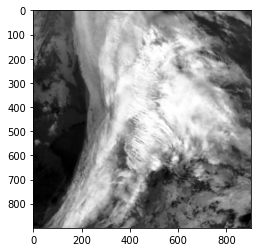

In [2]:
import torch
import argparse
from PIL import Image
import os
import numpy as np
from PIL import Image
import torchvision
from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T
from typing import List, Tuple, Dict, Optional
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from datetime import datetime, timedelta
from collections import Counter
import utils
import configparser
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin
from fil_finder import FilFinder2D
import astropy.units as u
import cv2
print((datetime.now()+timedelta(hours=9)).strftime('%Y-%m-%d %H:%M:%S'))
print("mask rcnn test start..")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cuda = torch.device('cuda')
plt.rcParams['figure.figsize'] = (14,4)
config = configparser.ConfigParser()    
config.read('setting.ini', encoding='utf-8') 

START_DATE = datetime.strptime(config['date']['start_date'],'%Y-%m-%d %H:%M:%S')
END_DATE = datetime.strptime(config['date']['end_date'],'%Y-%m-%d %H:%M:%S')
path = config['path']['test_path']
model_path = config['path']['model_path']

'''
annos = ['LLJ', 'W_SNOW','E_SNOW','WET_SN','CUM_SN','COLD_FRONT','WARM_FRONT','OCC_FRONT','H_POINT','L_POINT'
        ,'HLJ', 'TYPOON', 'R_START', 'R_STOP','RA_SN','HAIL']
modes = ['sat','rad']
label_num = [2,3,3,3,3,2,2,2,1,1,
                2,1,2,2,2,3]
'''

model_dir = model_path
data_path = os.path.join(path,'processed_data')
eval_path = os.path.join(path,'processed_data')

anno = 'COLD_FRONT'
mode = 'sat'

sample_path = '/aiwx_data/'
inputs = np.load(os.path.join(sample_path,'COLD_FRONT_image.npy'))
targets = np.load(os.path.join(sample_path,'COLD_FRONT_target.npy'))

print("sample data loading..")
plt.imshow(inputs, cmap='gray')

In [3]:
anno = 'COLD_FRONT'
mode = 'sat'
print("model loading..")
model = torch.load(os.path.join(model_dir,anno+'_'+mode+'.pt'))
model = model.cuda()
model.eval()

images = inputs
target = targets

model loading..


output mask


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


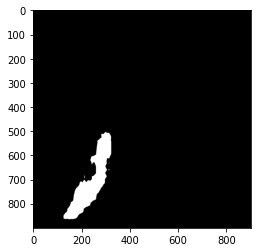

In [4]:
images = torch.tensor(images.reshape(1,1,900,900)).cuda().type(torch.float32)
output = model(images)

temp = output[0]['masks'][0].cpu().detach()[0].numpy()

temp [ temp > 0.5 ] = 1
temp [ temp <= 0.5 ] = 0

print("output mask")
plt.imshow(temp,cmap='gray')

/usr/local/lib/python3.9/dist-packages/fil_finder/filfinder2D.py:142: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
/usr/local/lib/python3.9/dist-packages/fil_finder/filfinder2D.py:296: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
/usr/local/lib/python3.9/dist-packages/fil_finder/filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


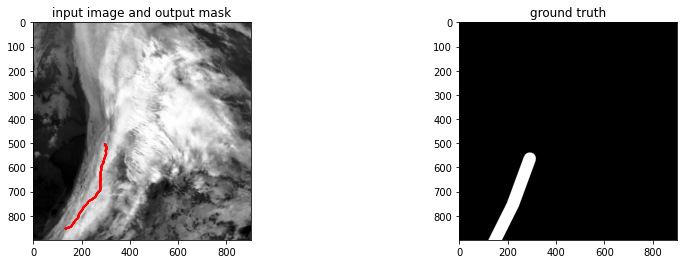

In [5]:

skeleton = skeletonize(temp)
skeleton = skeleton.astype(np.uint8)

fil = FilFinder2D(skeleton, distance=250 * u.pc, mask=skeleton)
fil.create_mask(border_masking=True, verbose=False,
use_existing_mask=True)
fil.medskel(verbose=False)
fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')

img = fil.skeleton_longpath.astype(np.uint8)*255
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels = cv2.connectedComponents(img)
label_hue = np.uint8(179*labels/np.max(labels))
val = list(Counter(label_hue.flatten()).keys())[1]
label_hue[label_hue!=val] = 0

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(inputs,cmap='gray')
ax1.contour(label_hue, colors='r')
ax1.set_title('input image and output mask')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(target,cmap='gray')
ax2.set_title('ground truth')

plt.show()
